# Demo Deep Belief Network para identificar clases
  Nota: se usa el modelo definido en https://github.com/albertbup/deep-belief-network

0) Instalar paquete de DBN: 
( para más info ver https://github.com/albertbup/deep-belief-network/blob/master/README.md )

In [1]:
#@title Chequea que sea una sesión GPU
# nota se debe indicar la versión 1 de TF para compatibilidad del código
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

TensorFlow 1.x selected.
1.15.2
Found GPU at: /device:GPU:0


In [2]:
#@title Instala el paquete 
#!pip install git+git://github.com/albertbup/deep-belief-network.git@master_gpu
!git clone https://github.com/albertbup/deep-belief-network.git
%cd deep-belief-network
!pip install -r requirements.txt

fatal: destination path 'deep-belief-network' already exists and is not an empty directory.
/content/deep-belief-network
  Using cached numpy-1.16.4-cp37-cp37m-manylinux1_x86_64.whl (17.3 MB)
  Using cached scipy-0.18.1.zip (14.6 MB)
  Using cached scikit-learn-0.18.1.tar.gz (8.9 MB)
ERROR: Could not find a version that satisfies the requirement tensorflow==1.5.0 (from versions: 1.13.1, 1.13.2, 1.14.0, 1.15.0, 1.15.2, 1.15.3, 1.15.4, 1.15.5, 2.0.0, 2.0.1, 2.0.2, 2.0.3, 2.0.4, 2.1.0, 2.1.1, 2.1.2, 2.1.3, 2.1.4, 2.2.0rc0, 2.2.0rc1, 2.2.0rc2, 2.2.0rc3, 2.2.0rc4, 2.2.0, 2.2.1, 2.2.2, 2.2.3, 2.3.0rc0, 2.3.0rc1, 2.3.0rc2, 2.3.0, 2.3.1, 2.3.2, 2.3.3, 2.3.4, 2.4.0rc0, 2.4.0rc1, 2.4.0rc2, 2.4.0rc3, 2.4.0rc4, 2.4.0, 2.4.1, 2.4.2, 2.4.3, 2.4.4, 2.5.0rc0, 2.5.0rc1, 2.5.0rc2, 2.5.0rc3, 2.5.0, 2.5.1, 2.5.2, 2.5.3, 2.6.0rc0, 2.6.0rc1, 2.6.0rc2, 2.6.0, 2.6.1, 2.6.2, 2.6.3, 2.7.0rc0, 2.7.0rc1, 2.7.0, 2.7.1, 2.8.0rc0, 2.8.0rc1, 2.8.0)
ERROR: No matching distribution found for tensorflow==1.5.0


1) Cargar librerías:

In [3]:
#@title Librerías a usar

# nota se debe indicar la versión 1 de TF para compatibilidad del código
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

from dbn.tensorflow import SupervisedDBNClassification # ojo que usa GPU
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt

import os
import csv

print ("Librerías cargadas.")

1.15.2

Librerías cargadas.


2) Cargar los datos:

In [4]:
# monta Google Drive:
# Nota: la primera vez se debe confirmar el uso logueandose en "Google Drive File Stream" y obteniendo código de autentificación.
from google.colab import drive
drive.mount('/content/gdrive')

# directorio local en Google Drive
path = '/content/gdrive/My Drive/IA/demoML/datos/'  #@param {type:"string"}

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
## selección de los parámetros 

def cargarNombreClases(path, archivo_datos, atributo_clase, nombre_clases):
  # importa definición de la clase
  arClasesFN = archivo_datos.split('.')[0] + '_nombreClases.txt'
  if os.path.isfile( path + '/' + arClasesFN ):
    with open( path + '/' + arClasesFN, mode='r') as csvfile:
        r = csv.reader(csvfile, delimiter=',')
        auxAtributo = r.__next__()
        auxClases = r.__next__()
    print('\n> Definición de los valores discretos para la clase cargada de ' + arClasesFN +'.\n')
    return auxAtributo[0], ','.join(auxClases)
  else:
    return atributo_clase, nombre_clases

#@markdown ### Archivo de datos a utilizar:
archivo_datos = 'IRIS.csv'  #@param {type:"string"}
#@markdown ### Nombre del atributo clase / objetivo:
atributo_clase = '-' #@param {type:"string"}
#@markdown ### Descripción de los valores del atributo clase / objetivo:  (nota: siempre debe comienzar en 0, por lo que si no tiene valor 0, agregar "na")
nombre_clases = '-' #@param {type:"string"}
#@markdown ### Porcentaje de datos para usar en el entrenamiento:
proporcion_porcentaje_datos_entrenamiento =   70#@param {type:"integer"}

## aplicación de los parámetros elegidos

if atributo_clase == '' or  atributo_clase == '-':
  # trata de obtener la configuración del archivo asociado
  atributo_clase, nombre_clases = cargarNombreClases(path, archivo_datos, atributo_clase, nombre_clases)


# define nombre atributo de CLASE para ejemplo IRIS
ClassAttributeName = atributo_clase

# define valores de clases para ejemplo IRIS
CLASES = [ ]
for val in nombre_clases.split(','):
  CLASES.append( val )

# determina la proporción a usar para entrenar y probar
if proporcion_porcentaje_datos_entrenamiento>100:
  propTrain = 1
elif proporcion_porcentaje_datos_entrenamiento<1:
  propTrain = 0.1
else:
  propTrain = proporcion_porcentaje_datos_entrenamiento/100

print("Configuración definida de ", archivo_datos)
print("Atributo clase: ", ClassAttributeName, ": ", CLASES)


> Definición de los valores discretos para la clase cargada de IRIS_nombreClases.txt.

Configuración definida de  IRIS.csv
Atributo clase:  Clase :  ['na', 'Setosa', 'Versicolor', 'Virginica']


In [6]:
#@title Cargar datos

# configura para que muestre todas las columnas y filas
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

# Carga los datos del CSV y muestra los primeros
df = pd.read_csv(path + archivo_datos)
print("\n> Cabecera: ")
print(df.head())
print("\n> Características: ")
print(df.describe())

# genera los datos solo con la clase para entrenar y probar
Y = np.array(df.pop(ClassAttributeName))
X = np.array(df)


> Cabecera: 
   LargoSepalo  AnchoSepalo  LargoPetalo  AnchoPetalo  Clase
0          5.1          3.5          1.4          0.2      1
1          4.9          3.0          1.4          0.2      1
2          4.7          3.2          1.3          0.2      1
3          4.6          3.1          1.5          0.2      1
4          5.0          3.6          1.4          0.2      1

> Características: 
       LargoSepalo  AnchoSepalo  LargoPetalo  AnchoPetalo       Clase
count   150.000000   150.000000   150.000000   150.000000  150.000000
mean      5.843333     3.054000     3.758667     1.198667    2.000000
std       0.828066     0.433594     1.764420     0.763161    0.819232
min       4.300000     2.000000     1.000000     0.100000    1.000000
25%       5.100000     2.800000     1.600000     0.300000    1.000000
50%       5.800000     3.000000     4.350000     1.300000    2.000000
75%       6.400000     3.300000     5.100000     1.800000    3.000000
max       7.900000     4.400000     6.9

In [7]:
#@title Normalizar datos de entrada (opcional)

aplica_normalizacion = True #@param {type:"boolean"}
#@markdown Si se aplica, seleccione el tipo de método de normalización a aplicar:
tipo_normalizacion = "Standard Scaler" #@param ["Standard Scaler", "MinMax Scaler", "MaxAbs Scaler", "Robust Scaler"]

if aplica_normalizacion:

  print("10 primeros datos de Entrada antes de normalizar: ")
  print(X[:10])

  from sklearn import preprocessing

  # elegir el método de normalización
  if tipo_normalizacion == "Standard Scaler": 
    scaler = preprocessing.StandardScaler()
  elif tipo_normalizacion == "MinMax Scaler": 
    scaler = preprocessing.MinMaxScaler()
  elif tipo_normalizacion == "MaxMax Scaler": 
    scaler = preprocessing.MaxAbsScaler()
  elif tipo_normalizacion == "Robust Scaler": 
    scaler = preprocessing.RobustScaler()
  
  # normaliza los datos de entrada
  X = scaler.fit_transform(X)

  print("\n\n10 primeros datos de Entrada después de normalizar: ")
  print(X[:10])

10 primeros datos de Entrada antes de normalizar: 
[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]
 [5.4 3.9 1.7 0.4]
 [4.6 3.4 1.4 0.3]
 [5.  3.4 1.5 0.2]
 [4.4 2.9 1.4 0.2]
 [4.9 3.1 1.5 0.1]]


10 primeros datos de Entrada después de normalizar: 
[[-0.90068117  1.03205722 -1.3412724  -1.31297673]
 [-1.14301691 -0.1249576  -1.3412724  -1.31297673]
 [-1.38535265  0.33784833 -1.39813811 -1.31297673]
 [-1.50652052  0.10644536 -1.2844067  -1.31297673]
 [-1.02184904  1.26346019 -1.3412724  -1.31297673]
 [-0.53717756  1.95766909 -1.17067529 -1.05003079]
 [-1.50652052  0.80065426 -1.3412724  -1.18150376]
 [-1.02184904  0.80065426 -1.2844067  -1.31297673]
 [-1.74885626 -0.35636057 -1.3412724  -1.31297673]
 [-1.14301691  0.10644536 -1.2844067  -1.4444497 ]]


In [8]:
#@title Preparar datos

# separa al azar usando muestreo estratificado con proporción indicada
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=(1-propTrain), stratify=Y)

# muestra resultados
print("> Para Ambos: ")
print(" - dictMapeo: ", CLASES)

print("\n> Para Entrenamiento: ")
print(" - x_train (cant ejemplos, datos entrada): ", x_train.shape)
print(" - y_train (cant): ", len(y_train))
for i in range(len(CLASES)):
  cant = 0
  for y in y_train:
    if i == y: cant = cant + 1
  print("    ", CLASES[i], "[", i, "]:", cant)

print("\n Para Prueba: ")
print(" - x_test (cant ejemplos, datos entrada): ", x_test.shape)
print(" - y_test (cant): ", len(y_test))
for i in range(len(CLASES)):
  cant = 0
  for y in y_test:
    if i == y: cant = cant + 1
  print("    ", CLASES[i], "[", i, "]:", cant)


> Para Ambos: 
 - dictMapeo:  ['na', 'Setosa', 'Versicolor', 'Virginica']

> Para Entrenamiento: 
 - x_train (cant ejemplos, datos entrada):  (104, 4)
 - y_train (cant):  104
     na [ 0 ]: 0
     Setosa [ 1 ]: 35
     Versicolor [ 2 ]: 34
     Virginica [ 3 ]: 35

 Para Prueba: 
 - x_test (cant ejemplos, datos entrada):  (46, 4)
 - y_test (cant):  46
     na [ 0 ]: 0
     Setosa [ 1 ]: 15
     Versicolor [ 2 ]: 16
     Virginica [ 3 ]: 15


3) Especificar el modelo para la DBN:

In [9]:
#@title Establecer el modelo
dbn_cant_neuronas_capas_ocultas = '128, 64' #@param {type:"string"}
RBM_cant_epocas_entrenamiento = 10 #@param {type:"integer"}
Backprop_cant_epocas_entrenamiento = 150 #@param {type:"integer"}

# cantidad de neuronas ocultas 
hidden_layers = []
for val in dbn_cant_neuronas_capas_ocultas.split(','):
  hidden_layers.append( int(val) )

classifier = SupervisedDBNClassification(hidden_layers_structure = hidden_layers,
              learning_rate_rbm=0.05,
              learning_rate=0.1,
              n_epochs_rbm=RBM_cant_epocas_entrenamiento,
              n_iter_backprop=Backprop_cant_epocas_entrenamiento,
              batch_size=32,
              activation_function='relu',
              dropout_p=0.2)

#print(classifier)
print("DBN definida")

DBN definida


4) Entrenar el modelo de la DBN:

In [10]:
#@title Entrenar
classifier.fit(x_train, y_train)

[START] Pre-training step:



Instructions for updating:
Use `tf.cast` instead.


>> Epoch 1 finished 	RBM Reconstruction error 3.170021
>> Epoch 2 finished 	RBM Reconstruction error 2.944135
>> Epoch 3 finished 	RBM Reconstruction error 2.706510
>> Epoch 4 finished 	RBM Reconstruction error 2.519400
>> Epoch 5 finished 	RBM Reconstruction error 2.516256
>> Epoch 6 finished 	RBM Reconstruction error 2.873395
>> Epoch 7 finished 	RBM Reconstruction error 3.470355
>> Epoch 8 finished 	RBM Reconstruction error 3.940921
>> Epoch 9 finished 	RBM Reconstruction error 4.961567
>> Epoch 10 finished 	RBM Reconstruction error 5.894978
>> Epoch 1 finished 	RBM Reconstruction error 44.197372
>> Epoch 2 finished 	RBM Reconstruction error 195.762909
>> Epoch 3 finished 	RBM Reconstruction error 232.733002
>> Epoch 4 finished 	RBM Reconstruction error 336.333984
>> Epoch 5 finished 	RBM Reconstruction error 311.622101
>> Epoch 6 finished 	RBM Reconstruction error 280.410522
>> Epoch 7 finished 	RBM R

SupervisedDBNClassification(batch_size=32, dropout_p=0.2,
                            idx_to_label_map={0: 2, 1: 1, 2: 3},
                            l2_regularization=1.0,
                            label_to_idx_map={1: 1, 2: 0, 3: 2},
                            learning_rate=0.1, n_iter_backprop=150,
                            verbose=True)


 Resultados: 
Clase predecida es "Versicolor"[2], la correcta es "Versicolor"[2] 
Clase predecida es "Setosa"[1], la correcta es "Setosa"[1] 
Clase predecida es "Versicolor"[2], la correcta es "Versicolor"[2] 
Clase predecida es "Setosa"[1], la correcta es "Setosa"[1] 
Clase predecida es "Setosa"[1], la correcta es "Setosa"[1] 
Clase predecida es "Setosa"[1], la correcta es "Setosa"[1] 
Clase predecida es "Virginica"[3], la correcta es "Virginica"[3] 
Clase predecida es "Versicolor"[2], la correcta es "Versicolor"[2] 
Clase predecida es "Setosa"[1], la correcta es "Setosa"[1] 
Clase predecida es "Versicolor"[2], la correcta es "Versicolor"[2] 
Clase predecida es "Setosa"[1], la correcta es "Setosa"[1] 
Clase predecida es "Virginica"[3], la correcta es "Virginica"[3] 
Clase predecida es "Setosa"[1], la correcta es "Setosa"[1] 
Clase predecida es "Versicolor"[2], la correcta es "Versicolor"[2] 
Clase predecida es "Virginica"[3], la correcta es "Virginica"[3] 
Clase predecida es "Setosa"

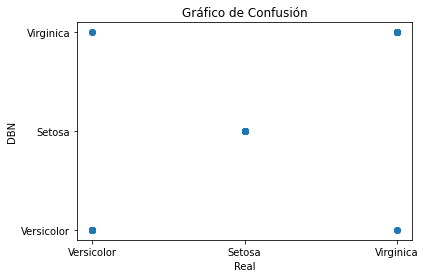

In [11]:
#@title Evaluar el modelo con datos de entrenamiento

# ejecuta el  modelo
y_pred = classifier.predict(x_train)

# calcula la exactitud
#print('\nExactitud: %f' % accuracy_score(y_train, y_pred))

# muestra resultados de la predicción
classPreds = []
classReal = []
cantOK = 0
cantError = 0
print("\n Resultados: ")
for pred_class_id, expec in zip(y_pred, y_train):
    
    classPreds.append(CLASES[pred_class_id])
    classReal.append(CLASES[expec])

    if (pred_class_id == expec): 
      res = ""
      cantOK += 1
    else: 
      res = "!"
      cantError += 1

    print('Clase predecida es "{}"[{}], la correcta es "{}"[{}]{} '.format(
        CLASES[pred_class_id], pred_class_id, CLASES[expec], expec, res))

print('=== Total Ejemplos: {}, con {} predicciones ok y {} errores.'.format(cantOK+cantError, cantOK, cantError))

# gráfico de comparación
plt.title('Gráfico de Confusión')
plt.xlabel('Real')
plt.ylabel('DBN')
plt.scatter(classReal, classPreds)

# muestra reporte de clasificación
print("\n Reporte de Clasificación: ")
print(classification_report(classReal, classPreds))

# muestra matriz de confusion
print('\nMatriz de Confusión: ')
cm = confusion_matrix(classReal, classPreds, labels=CLASES)
cmtx = pd.DataFrame(
    cm, 
    index=['r:{:}'.format(x) for x in CLASES], 
    columns=['p:{:}'.format(x) for x in CLASES]
  )
print(cmtx)
print("\n")


5) Evaluar el modelo de la RNA entrenado:


Exactitud: 0.978261

 Resultados: 
Clase predecida es "Setosa"[1], la correcta es "Setosa"[1] 
Clase predecida es "Versicolor"[2], la correcta es "Versicolor"[2] 
Clase predecida es "Setosa"[1], la correcta es "Setosa"[1] 
Clase predecida es "Virginica"[3], la correcta es "Virginica"[3] 
Clase predecida es "Virginica"[3], la correcta es "Virginica"[3] 
Clase predecida es "Versicolor"[2], la correcta es "Versicolor"[2] 
Clase predecida es "Versicolor"[2], la correcta es "Versicolor"[2] 
Clase predecida es "Virginica"[3], la correcta es "Virginica"[3] 
Clase predecida es "Virginica"[3], la correcta es "Virginica"[3] 
Clase predecida es "Setosa"[1], la correcta es "Setosa"[1] 
Clase predecida es "Virginica"[3], la correcta es "Virginica"[3] 
Clase predecida es "Setosa"[1], la correcta es "Setosa"[1] 
Clase predecida es "Setosa"[1], la correcta es "Setosa"[1] 
Clase predecida es "Versicolor"[2], la correcta es "Versicolor"[2] 
Clase predecida es "Setosa"[1], la correcta es "Setosa"[1] 
Cl

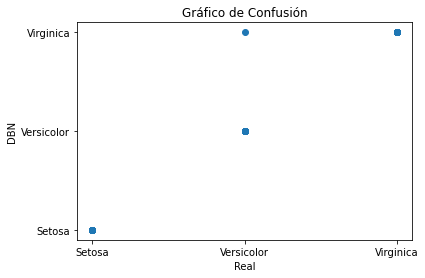

In [12]:
#@title Evaluar el modelo con datos de prueba

# ejecuta el  modelo
y_pred = classifier.predict(x_test)

# calcula la exactitud
print('\nExactitud: %f' % accuracy_score(y_test, y_pred))

# muestra resultados de la predicción
classPreds = []
classReal = []
cantOK = 0
cantError = 0
print("\n Resultados: ")
for pred_class_id, expec in zip(y_pred, y_test):
    
    classPreds.append(CLASES[pred_class_id])
    classReal.append(CLASES[expec])

    if (pred_class_id == expec): 
      res = ""
      cantOK += 1
    else: 
      res = "!"
      cantError += 1

    print('Clase predecida es "{}"[{}], la correcta es "{}"[{}]{} '.format(
        CLASES[pred_class_id], pred_class_id, CLASES[expec], expec, res))

print('=== Total Ejemplos: {}, con {} predicciones ok y {} errores.'.format(cantOK+cantError, cantOK, cantError))

# gráfico de comparación
plt.title('Gráfico de Confusión')
plt.xlabel('Real')
plt.ylabel('DBN')
plt.scatter(classReal, classPreds)

# muestra reporte de clasificación
print("\n Reporte de Clasificación: ")
print(classification_report(classReal, classPreds))

# muestra matriz de confusion
print('\nMatriz de Confusión: ')
cm = confusion_matrix(classReal, classPreds, labels=CLASES)
cmtx = pd.DataFrame(
    cm, 
    index=['r:{:}'.format(x) for x in CLASES], 
    columns=['p:{:}'.format(x) for x in CLASES]
  )
print(cmtx)
print("\n")


In [13]:
#@title Inspeccionar influencia de los Atributos de Entrada
# fuente: https://scikit-learn.org/stable/modules/permutation_importance.html

from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer

# define la función para calculo del error
# contando la cantidad de diferencias 
# entre clase real y predecida
def calc_error(realClasses, predClasses):
    res = 0
    for i in range(len(realClasses)):
      res = res + abs(realClasses[i]-predClasses[i])
    return res
errorScorer = make_scorer(calc_error, greater_is_better=False)

def realizarInspeccion(tipoDatos, xScoring, yScoring):
  print("")
  # Genera el scoring usando permutaciones 
  # para realizar el cálculo del scoring
  scoring = {'R2 score':'r2', 
             'Error de Clase':errorScorer}
  r_multi  = permutation_importance(classifier, xScoring, yScoring,
                              n_repeats=30,
                              random_state=0,
                              scoring=scoring)

  # muesta las métricas
  print("> Cálculo de influencia con datos de " + tipoDatos + ":")
  for metric in r_multi:
    print("- Métrica "+metric+":")
    r = r_multi[metric]
    i = 0
    for imp in r.importances:
        print(f"\tAtributo {i:<2} [ {df.columns[i]} ]:  "
              f"{np.mean(imp):.3f} ± {np.std(imp):.3f}"
              f" [ {np.min(imp):.3f}; {np.max(imp):.3f} ]"
              )
        i = i + 1
  return

# Ejecuta con ambos sets de datos
realizarInspeccion(tipoDatos="Entrenamiento",  
                  xScoring = x_train,
                  yScoring = y_train)

realizarInspeccion(tipoDatos="Prueba",  
                  xScoring = x_test,
                  yScoring = y_test)




> Cálculo de influencia con datos de Entrenamiento:
- Métrica R2 score:
	Atributo 0  [ LargoSepalo ]:  -0.001 ± 0.021 [ -0.043; 0.043 ]
	Atributo 1  [ AnchoSepalo ]:  0.076 ± 0.026 [ 0.029; 0.129 ]
	Atributo 2  [ LargoPetalo ]:  0.310 ± 0.046 [ 0.200; 0.400 ]
	Atributo 3  [ AnchoPetalo ]:  0.392 ± 0.060 [ 0.271; 0.514 ]
- Métrica Error de Clase:
	Atributo 0  [ LargoSepalo ]:  -0.067 ± 1.436 [ -3.000; 3.000 ]
	Atributo 1  [ AnchoSepalo ]:  5.233 ± 1.874 [ 2.000; 9.000 ]
	Atributo 2  [ LargoPetalo ]:  21.667 ± 3.208 [ 14.000; 28.000 ]
	Atributo 3  [ AnchoPetalo ]:  27.433 ± 4.201 [ 19.000; 36.000 ]

> Cálculo de influencia con datos de Prueba:
- Métrica R2 score:
	Atributo 0  [ LargoSepalo ]:  -0.004 ± 0.011 [ -0.033; 0.000 ]
	Atributo 1  [ AnchoSepalo ]:  0.020 ± 0.029 [ -0.033; 0.100 ]
	Atributo 2  [ LargoPetalo ]:  0.374 ± 0.077 [ 0.200; 0.500 ]
	Atributo 3  [ AnchoPetalo ]:  0.496 ± 0.102 [ 0.200; 0.767 ]
- Métrica Error de Clase:
	Atributo 0  [ LargoSepalo ]:  -0.133 ± 0.340 [ -1.0